In [1]:
import ete3
import os
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS
from scipy.stats import wilcoxon, ttest_ind
import re
import multiprocessing
import subprocess
from collections import Counter
import matplotlib.colors
#import plotly
#import plotly.plotly as ptl
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

%cd /work/site_rate/hug_et_al

/work/site_rate/hug_et_al


In [2]:
tree = ete3.Tree('ribosomal_concat_ml_tree-regular_support.tre')
bacteria     = []
archaea      = []
eukarya      = []
for leaf in tree.get_leaf_names():
    if leaf.startswith('Bacteria'):
        bacteria.append(leaf)
    elif leaf.startswith('Archaea'):
        archaea.append(leaf)
    elif leaf.startswith('Eukaryota'):
        eukarya.append(leaf)

tree.set_outgroup(eukarya[0])
bacteria_ancestor = tree.get_common_ancestor(bacteria)
tree.set_outgroup(bacteria_ancestor)

bipartitions   = []
branch_lengths = []
for node in tree.traverse():
    if node.is_leaf() or node.is_root():
        continue
    bipartitions.append(set(node.get_leaf_names()))
    branch_lengths.append(node.dist)

In [71]:
archaea_tree = tree.get_common_ancestor(archaea).copy()
archaea_branch_lengths = np.asarray(
                         [node.dist for node in archaea_tree.traverse()
                          if not node.is_leaf() and not node.is_root()]
)

In [114]:
yeah = pd.read_table('rate_binning.rate', comment='#')
yeah.head()

,Site,Rate,Cat,C_Rate
0,1,0.08971,2,0.08971
1,2,1.19779,9,1.21474
2,3,0.54594,6,0.54580
3,4,0.54580,6,0.54580
4,5,1.21474,9,1.21474


In [209]:
branch_length = 0.05
branch_length * 2596

129.8

In [255]:
tmp = []
src_proportions = [0.036, 0.070, 0.072, 0.095, 0.110, 0.108, 0.113, 0.106, 0.110, 0.083, 0.075, 0.022]
for cat in range(1, 13):
    avg_rate  = yeah.Rate[yeah.Cat==cat].median()
    num_sites = 1/12
    tmp.append(
        branch_length * avg_rate * num_sites
    )
tmp = np.asarray(tmp)
sum(tmp)

0.04999995833333333

In [291]:
tmp = []
src_proportions = [0.036, 0.070, 0.072, 0.095, 0.110, 0.108, 0.113, 0.106, 0.110, 0.083, 0.075, 0.022]
for cat in range(1, 13):
    avg_rate  = yeah.Rate[yeah.Cat==cat].median()
    num_sites = yeah.Rate[yeah.Cat==cat].shape[0]/2596
    tmp.append(
        ((branch_length * avg_rate) * num_sites) / branch_length
    )
tmp = np.asarray(tmp)
sum(tmp)

0.8437643451463791

In [290]:
tmp*129.8

array([ 0.108438 ,  0.8208465,  1.647256 ,  3.421983 ,  5.705985 ,
        7.66849  , 10.5987   , 12.839777 , 17.370782 , 17.15399  ,
       21.285195 , 10.8991695])

In [320]:
tmp = []
for cat in range(1, 13):
    avg_rate = yeah.Rate[yeah.Cat==cat].median()
    num_sites = 1/12
    tmp.append(
        ((branch_length * avg_rate) * num_sites) / 0.1
    )
tmp = np.asarray(tmp)
sum(tmp)

0.9999991666666666

In [293]:
tmp*129.8

array([ 0.25224467,  0.97036317,  1.89551267,  3.00930483,  4.33120967,
        5.90373667,  7.79881667, 10.13748817, 13.13943767, 17.26037133,
       23.7355525 , 41.36585383])

In [341]:
tmp = []
for cat in [0.016, 0.523, 2.46]:
    avg_rate  = cat
    num_sites = 1/3
    tmp.append(
        ((0.026 * avg_rate) * num_sites) / 0.026
    )
tmp = np.asarray(tmp)
sum(tmp)

0.9996666666666666

In [343]:
tmp*26

array([ 0.13866667,  4.53266667, 21.32      ])

In [314]:
tmp*26

array([1.66666667e-02, 1.83333333e+00, 2.41666667e+01])

In [8]:
rates = pd.read_table('rate_binning.rate', comment='#')
rates.drop_duplicates('Cat', inplace=True)
rates.sort_values('Cat', inplace=True)

cmap = plt.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-1, vmax=12)
colors = ['#%02x%02x%02x' % cmap(norm(index), bytes=8)[:3]
          for index in range(0,13)]

In [5]:
compatible_branch_lengths = []
for category in range(1, 13):
    suptree = ete3.Tree('categories/%i.fu.boot.ufboot.suptree' % category)
    compatible_branch_lengths.append(
        [node.dist for node in suptree.traverse() if not node.is_leaf() and
                                                     not node.is_root() and
                                                         node.support >= 80]
    )

1
2
3
4
5
6
7
8
9
10
11
12


In [32]:
compatible_branch_lengths = []
for category in range(1, 13):
    suptree = ete3.Tree('categories/%i.boot.ufboot.suptree' % category)
    compatible_branch_lengths.append(
        [node.dist for node in suptree.traverse() if not node.is_leaf() and
                                                     not node.is_root() and
                                                         node.support >= 80]
    )

#3d7ab8, #7190c5, #98a7d2, #bbc0df, #dadaec, #dcd7ec, #e0d4ea, #e4d1e8, #dbaccb, #d587a3, #ca6273, #b4423c);

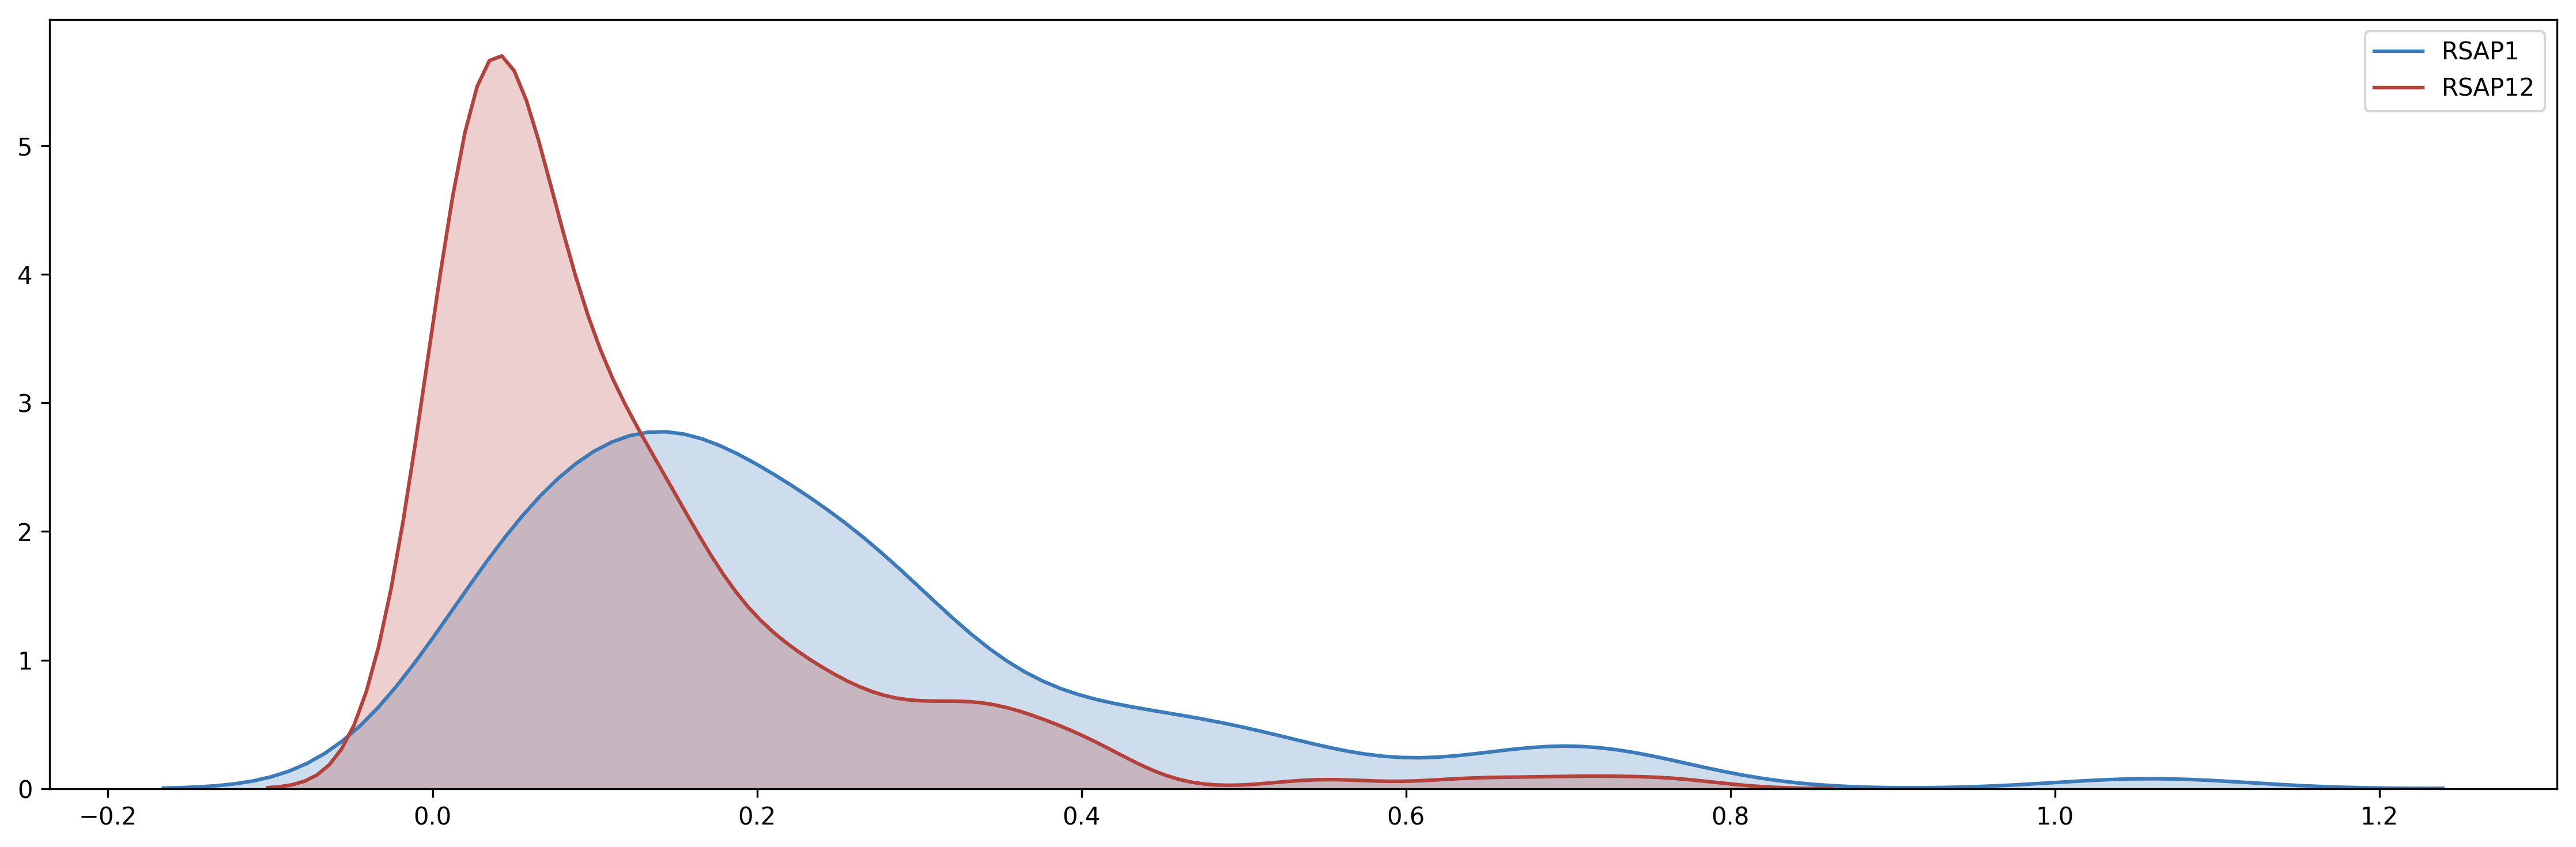

In [360]:
fig, ax = plt.subplots(dpi=300, figsize=(15,5))
sns.kdeplot(compatible_branch_lengths[0], shade=True, ax=ax, label='RSAP1', color='#3d7ab8')
sns.kdeplot(compatible_branch_lengths[-1], shade=True, ax=ax, label='RSAP12', color='#b4423c')
fig.tight_layout()

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



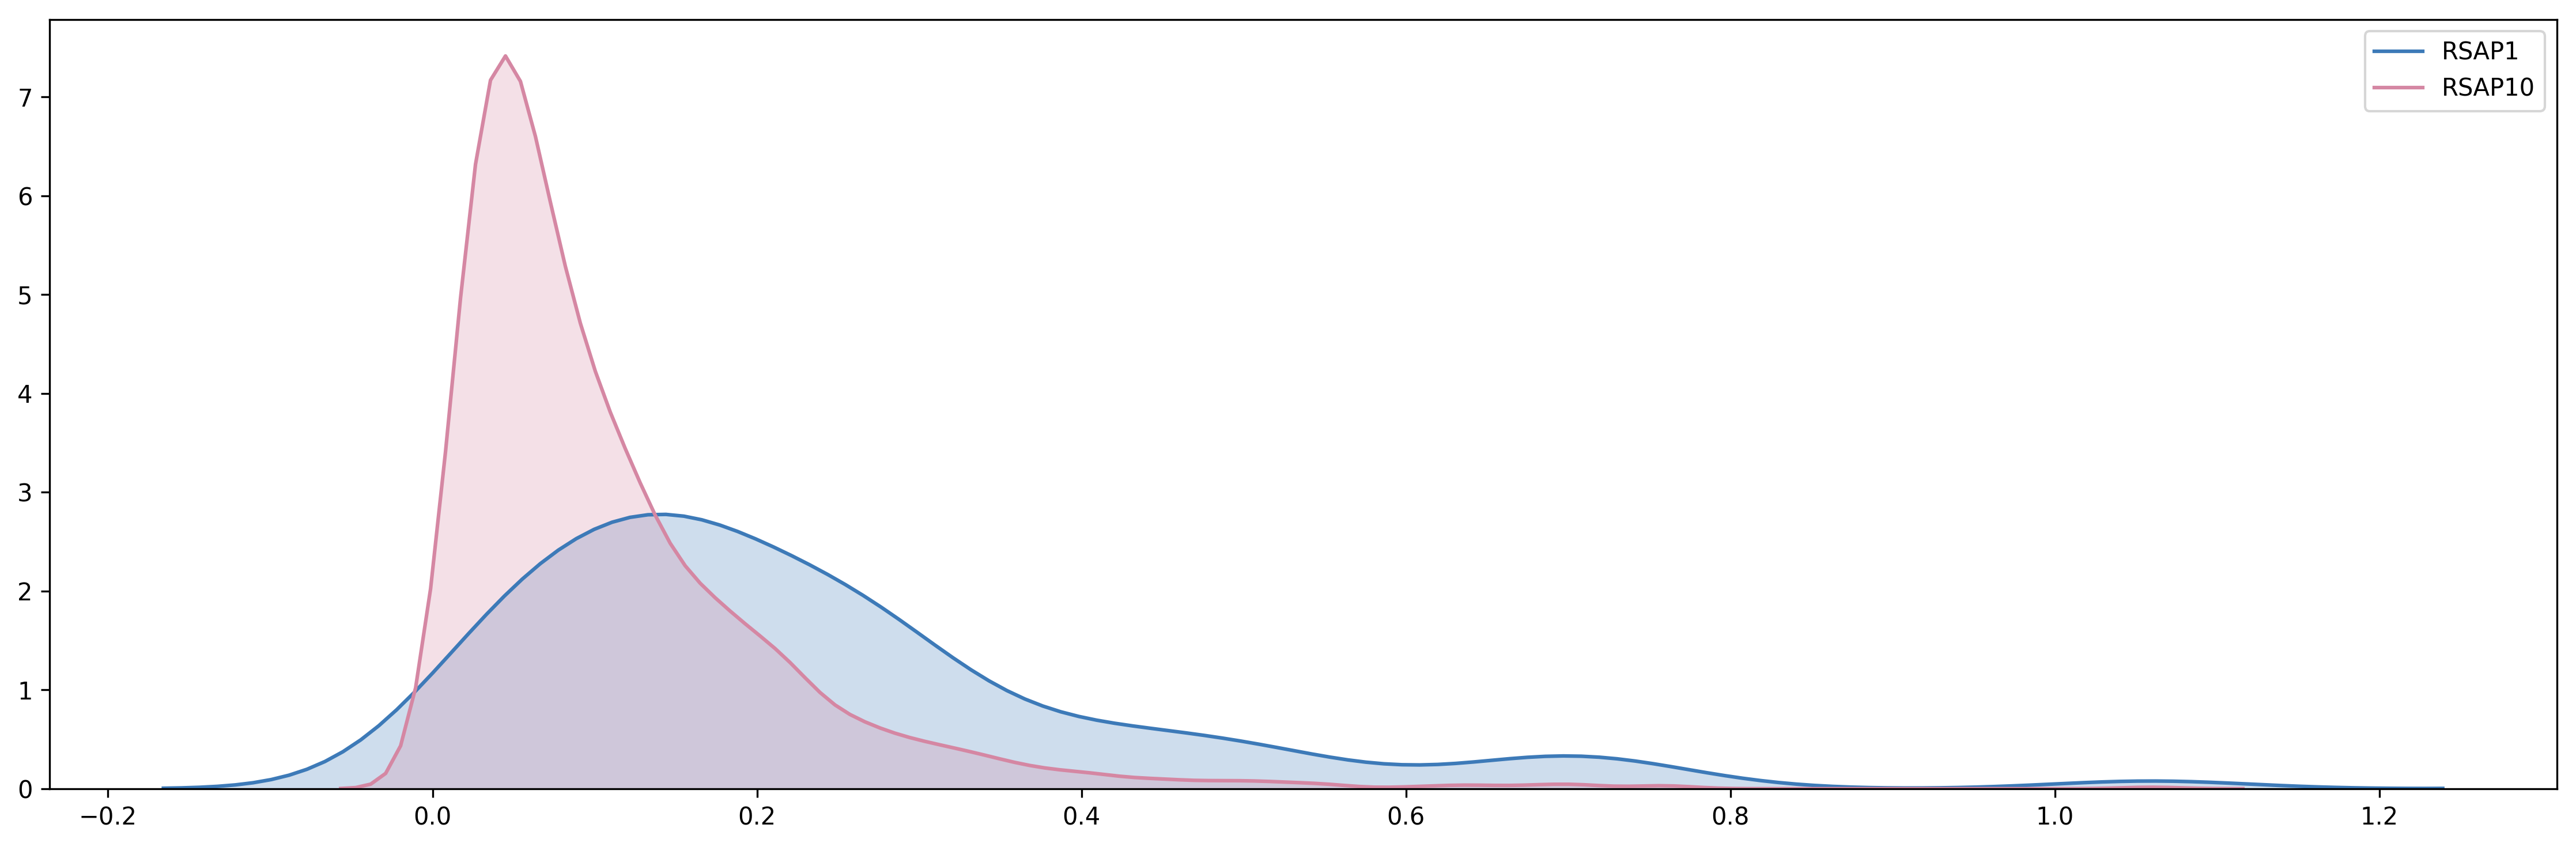

In [386]:
fig, ax = plt.subplots(dpi=300, figsize=(15,5))
sns.kdeplot(compatible_branch_lengths[0], shade=True, ax=ax, label='RSAP1', color='#3d7ab8')
sns.kdeplot(compatible_branch_lengths[-3], shade=True, ax=ax, label='RSAP10', color='#d587a3')
fig.tight_layout()

In [385]:
sum(np.asarray(compatible_branch_lengths[0]) > 1)

1

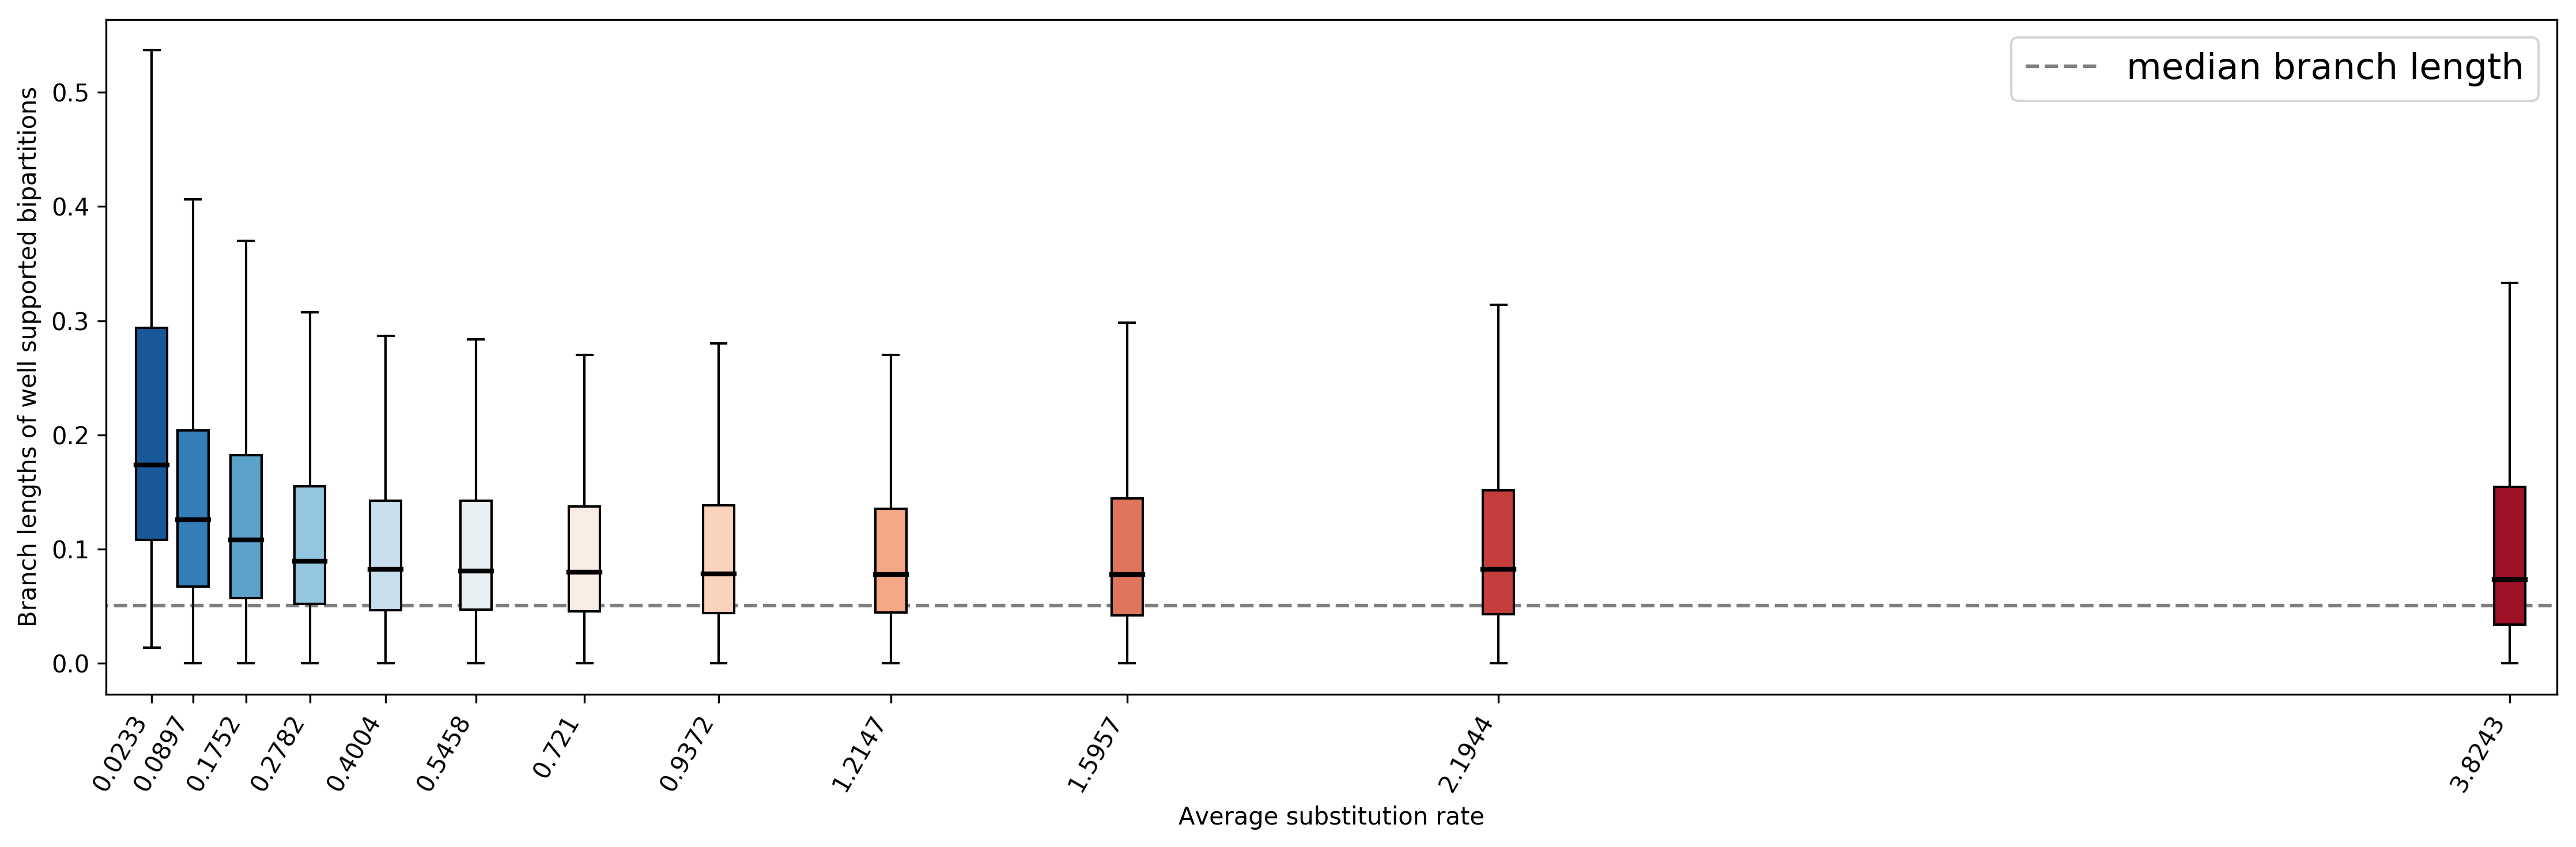

In [406]:
fig, ax = plt.subplots(dpi=300, figsize=(15,5))
boxplot = ax.boxplot(compatible_branch_lengths, positions=rates.C_Rate.tolist(),
                     widths=0.05,
                     patch_artist=True,
                     showfliers=False,
                     boxprops={'linewidth':1},
                     whiskerprops={'linewidth':1},
                     medianprops={'linewidth':2,
                                  'color':'k'},)
ax.plot(ax.get_xlim(), [np.median(branch_lengths), np.median(branch_lengths)], '--',
        c='k', alpha=0.5, label='median branch length')

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
        
ax.set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
ax.set_xlabel('Average substitution rate')
ax.set_ylabel('Branch lengths of well supported bipartitions')
ax.set_xlim(-0.05,3.9)
ax.legend(prop=dict(size=15))
fig.tight_layout()
fig.savefig('/Users/thiberio/Dropbox (MIT)/site_rates-paper/final figures/Figure 2a.pdf')

In [31]:
spearmanr([np.median(n) for n in compatible_branch_lengths],
          rates.C_Rate.tolist())

SpearmanrResult(correlation=-0.9720279720279721, pvalue=1.2868115751495013e-07)

In [97]:
%cd /work/site_rate/hug_et_al/
trees = []
names = []
random.seed(12345)
for category in range(1,13):
    ufboot = open('categories/%i.fu.boot.ufboot' % category).read().split('\n')
    ufboot.pop()
    trees.extend(random.sample(ufboot, 100))
    names.extend(['rate_%i' % category]*100)
trees.append(open('ribosomal_concat-original.tre').read().strip())
names.append('Full tree')
trees.append(open('best_phylogenies/just_mid_evolving_sites.aln.treefile').read().strip())
names.append('Only optimal categories')
trees.append(open('best_phylogenies/no_slow_evolving_sites.aln.treefile').read().strip())
names.append('No slow sites')
trees.append(open('best_phylogenies/no_fast_evolving_sites.aln.treefile').read().strip())
names.append('No fast sites')

/work/site_rate/hug_et_al


In [98]:
out = open('rf_trees_individual_cats.treelist', 'w')
out.write('\n'.join(trees))
out.close()

subprocess.call(['iqtree', '-t', 'rf_trees_individual_cats.treelist', '-rf_all', '-nt', '15'])

0

In [99]:
distances = []
for line in open('rf_trees_individual_cats.treelist.rfdist').readlines()[1:]:
    line = line.split()[1:]
    distances.append([float(value) for value in line])

df = pd.DataFrame(index=names, columns=names, data=distances)

In [100]:
df.head()

,rate_1,rate_1,rate_1,rate_1,rate_1,rate_1,rate_1,rate_1,rate_1,rate_1,...,rate_12,rate_12,rate_12,rate_12,rate_12,rate_12,Full tree,Only optimal categories,No slow sites,No fast sites
rate_1,0.0,4688.0,3382.0,4682.0,4676.0,4672.0,3384.0,4692.0,4696.0,4700.0,...,6124.0,6124.0,6124.0,6124.0,6124.0,6124.0,5970.0,5972.0,5980.0,5974.0
rate_1,4688.0,0.0,4668.0,3354.0,3358.0,3354.0,4688.0,3364.0,3362.0,3440.0,...,6126.0,6126.0,6126.0,6126.0,6126.0,6126.0,5974.0,5976.0,5982.0,5978.0
rate_1,3382.0,4668.0,0.0,4694.0,4680.0,4686.0,3386.0,4668.0,4688.0,4698.0,...,6124.0,6124.0,6124.0,6124.0,6124.0,6124.0,5970.0,5974.0,5980.0,5974.0
rate_1,4682.0,3354.0,4694.0,0.0,3364.0,3364.0,4688.0,3370.0,3372.0,3424.0,...,6126.0,6126.0,6126.0,6126.0,6126.0,6126.0,5976.0,5978.0,5984.0,5978.0
rate_1,4676.0,3358.0,4680.0,3364.0,0.0,3370.0,4660.0,3388.0,3352.0,3442.0,...,6128.0,6128.0,6128.0,6128.0,6128.0,6128.0,5976.0,5980.0,5984.0,5980.0


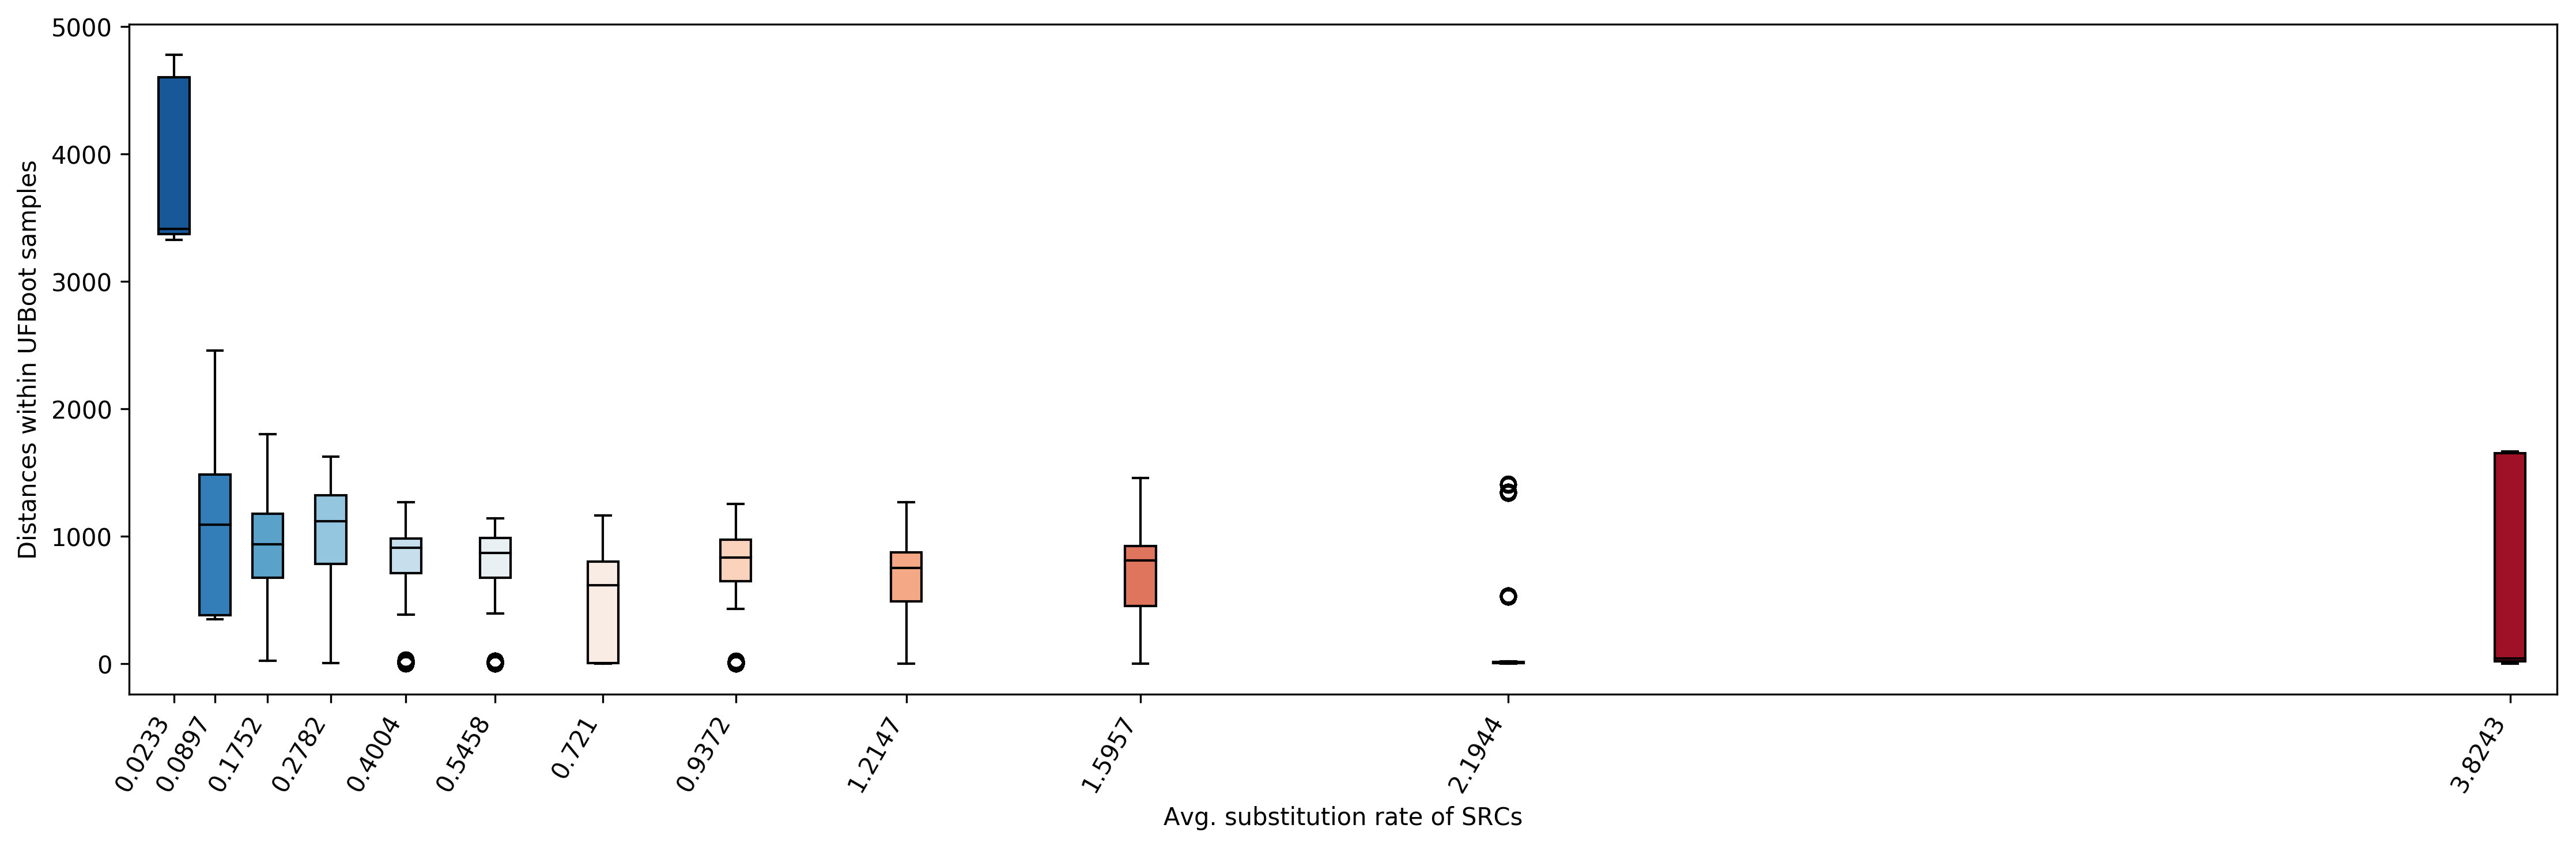

In [401]:
intra_distances = []
for category in range(1,13):
    category_indexes = df.index[df.index == 'rate_%i' % category]
    tmp_df = df.loc[df.index=='rate_%i' % category, df.columns=='rate_%i' % category].copy()
    intra_distances.append(squareform(tmp_df.values))

fig, ax = plt.subplots(dpi=300, figsize=(15,5))
boxplot = ax.boxplot(intra_distances, positions=rates.C_Rate.tolist(),
                     widths=0.05,
                     patch_artist=True,
                     boxprops={'linewidth':1},
                     whiskerprops={'linewidth':1},
                     medianprops={'linewidth':1,
                                  'color':'k'},)
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Distances within UFBoot samples')
ax.set_xlabel('Avg. substitution rate of SRCs')
ax.set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
ax.set_xlim(-0.05,3.9)

fig.tight_layout()
fig.savefig('/Users/thiberio/Dropbox (MIT)/site_rates-paper/final figures/Figure S1b.pdf')

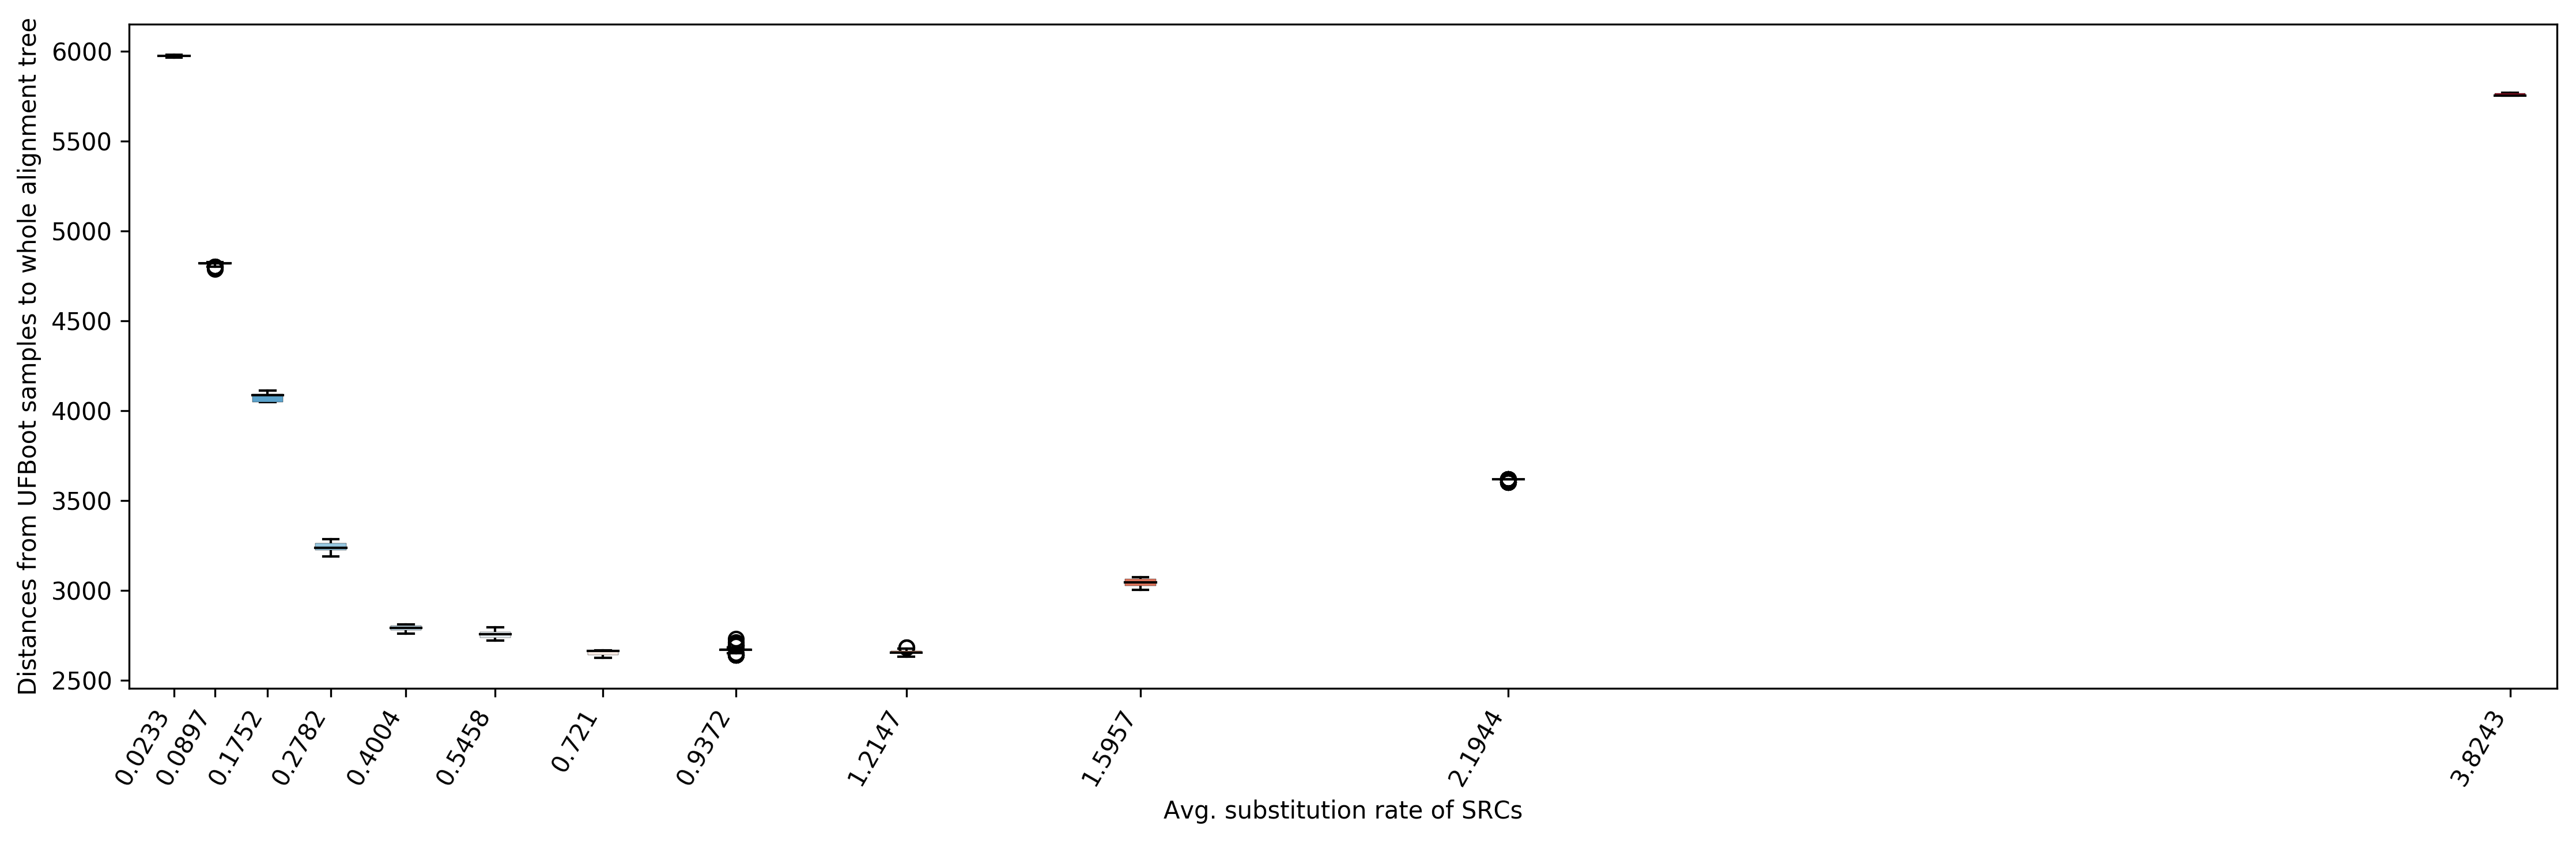

In [403]:
fig, ax = plt.subplots(dpi=300, figsize=(15,5))

whole_alignment_indexes = df.index[df.index.str.startswith('Full tree')]
distances_to_whole_aln = []
for category in range(1,13):
    category_indexes = df.index[df.index == 'rate_%i' % category]
    tmp_df = df.loc[df.index=='rate_%i' % category, df.columns=='Full tree'].copy()
    distances_to_whole_aln.append(tmp_df.values.flatten())

boxplot = ax.boxplot(distances_to_whole_aln, positions=rates.C_Rate.tolist(),
                         widths=0.05,
                         patch_artist=True,
                         showfliers=True,
                         boxprops={'linewidth':0.1},
                         whiskerprops={'linewidth':1},
                         medianprops={'linewidth':1,
                                      'color':'k'},)
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
ax.set_ylabel('Distances from UFBoot samples to whole alignment tree')
ax.set_xlabel('Avg. substitution rate of SRCs')
ax.set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
ax.set_xlim(-0.05,3.9)

fig.tight_layout()
fig.savefig('/Users/thiberio/Dropbox (MIT)/site_rates-paper/final figures/Figure 1a.pdf')

In [64]:
from scipy.stats import linregress
x = rates.C_Rate.tolist()[-4:]
y = [np.median(n) for n in distances_to_whole_aln[-4:]]
linregress(x,y)

LinregressResult(slope=1198.2341224618765, intercept=1122.673768513574, rvalue=0.9977130588480275, pvalue=0.0022869411519724774, stderr=57.400420966981486)

In [396]:
df.drop?

In [397]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=6)
tmp_df = df.drop(labels=['No slow sites', 'No fast sites', 'Only optimal categories']).copy()
tmp_df.drop(axis=1, labels=['No slow sites', 'No fast sites', 'Only optimal categories'], inplace=True)
coords    = embedding.fit_transform(tmp_df.values)
coords_df = pd.DataFrame(data=coords, columns='x y'.split(), index=tmp_df.index)

coords_df['gene_type'] = coords_df.index.tolist()
for category in range(1,13):
    coords_df.loc[coords_df['gene_type'] == 'rate_%i' %category, 'gene_type'] = 'RSAP%i' % category
coords_df.loc[coords_df['gene_type'] == 'Full tree', 'gene_type'] = 'whole alignment'

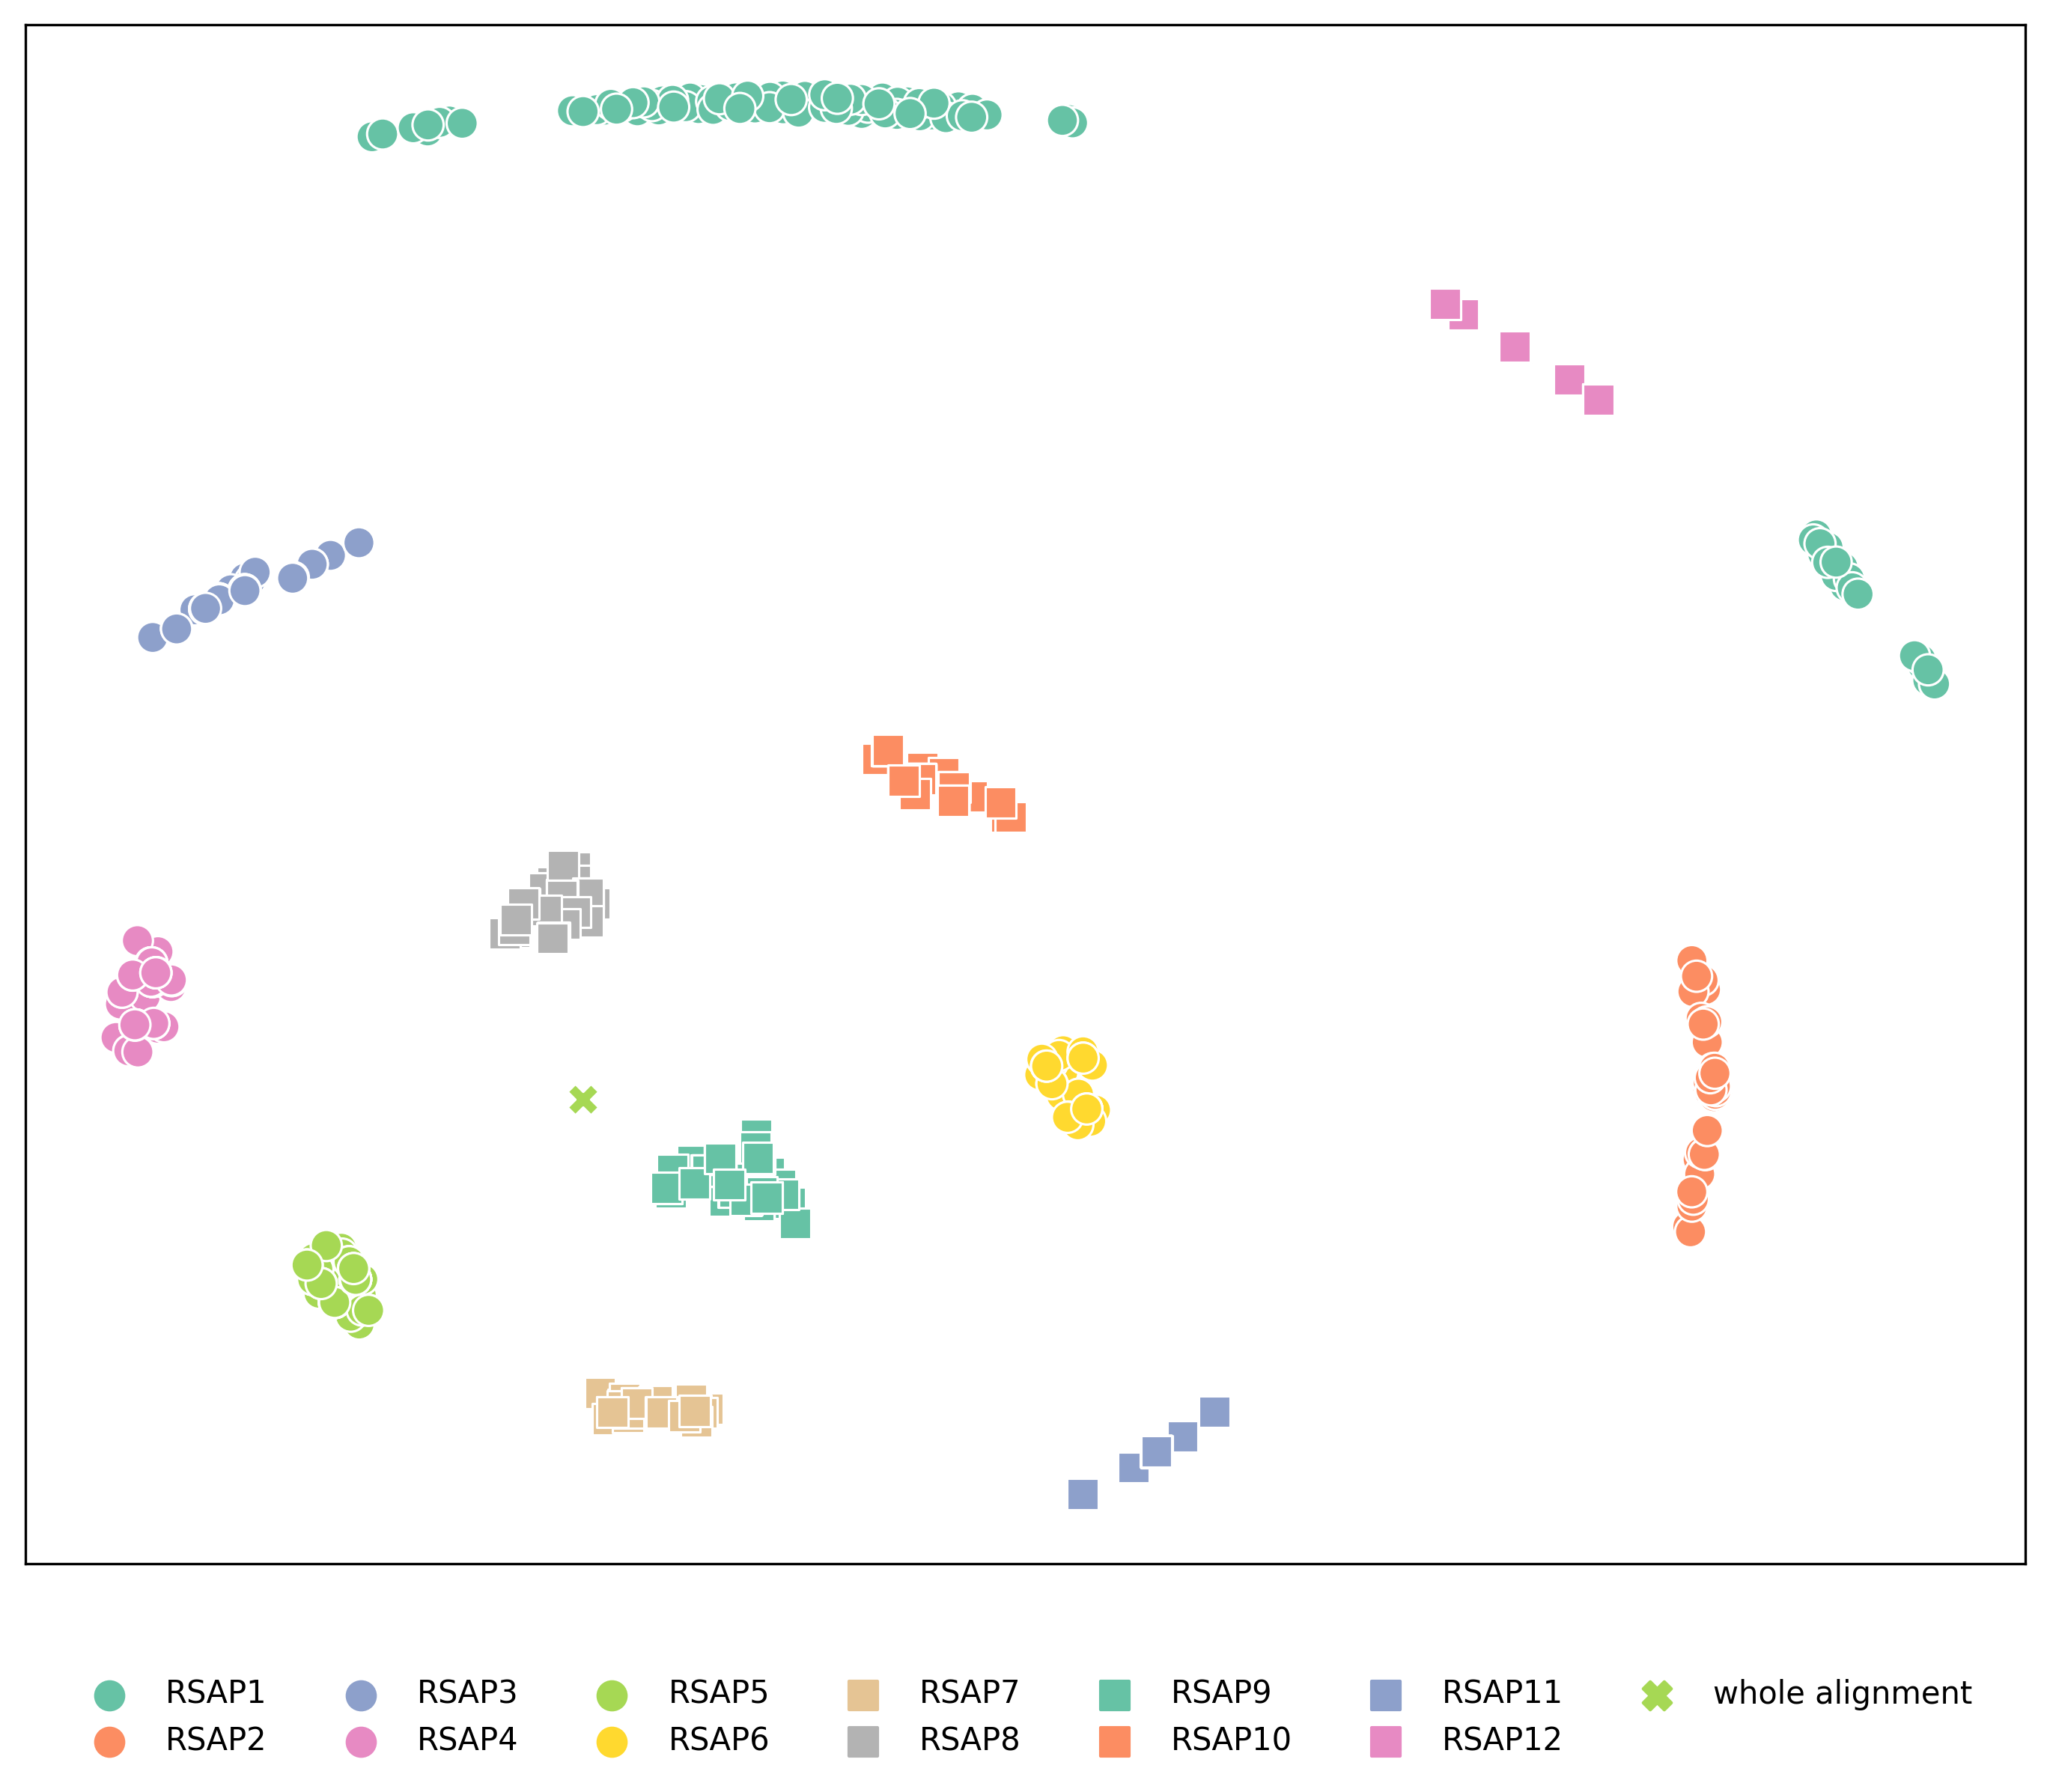

In [400]:
markers = {'RSAP%i' % num:'o' for num in range(1,7)}
markers.update({'RSAP%i' % num:'s' for num in range(7,13)})
markers['whole alignment'] = 'X'
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
sns.scatterplot(x='x', y='y', hue='gene_type',
                style='gene_type', data=coords_df,
                ax=ax, s=100, palette="Set2",
                markers=markers, alpha=1)
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks([])
plt.yticks([])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], markerscale=1.5,
          loc=10, bbox_to_anchor=(0.5, -0.1), ncol=7, frameon=False)
fig.tight_layout()
fig.savefig('/Users/thiberio/Dropbox (MIT)/site_rates-paper/final figures/Figure S1a.pdf')

In [92]:
1442/2598

0.5550423402617398

In [61]:
tree_linkage = linkage(squareform(df.values), method='single')

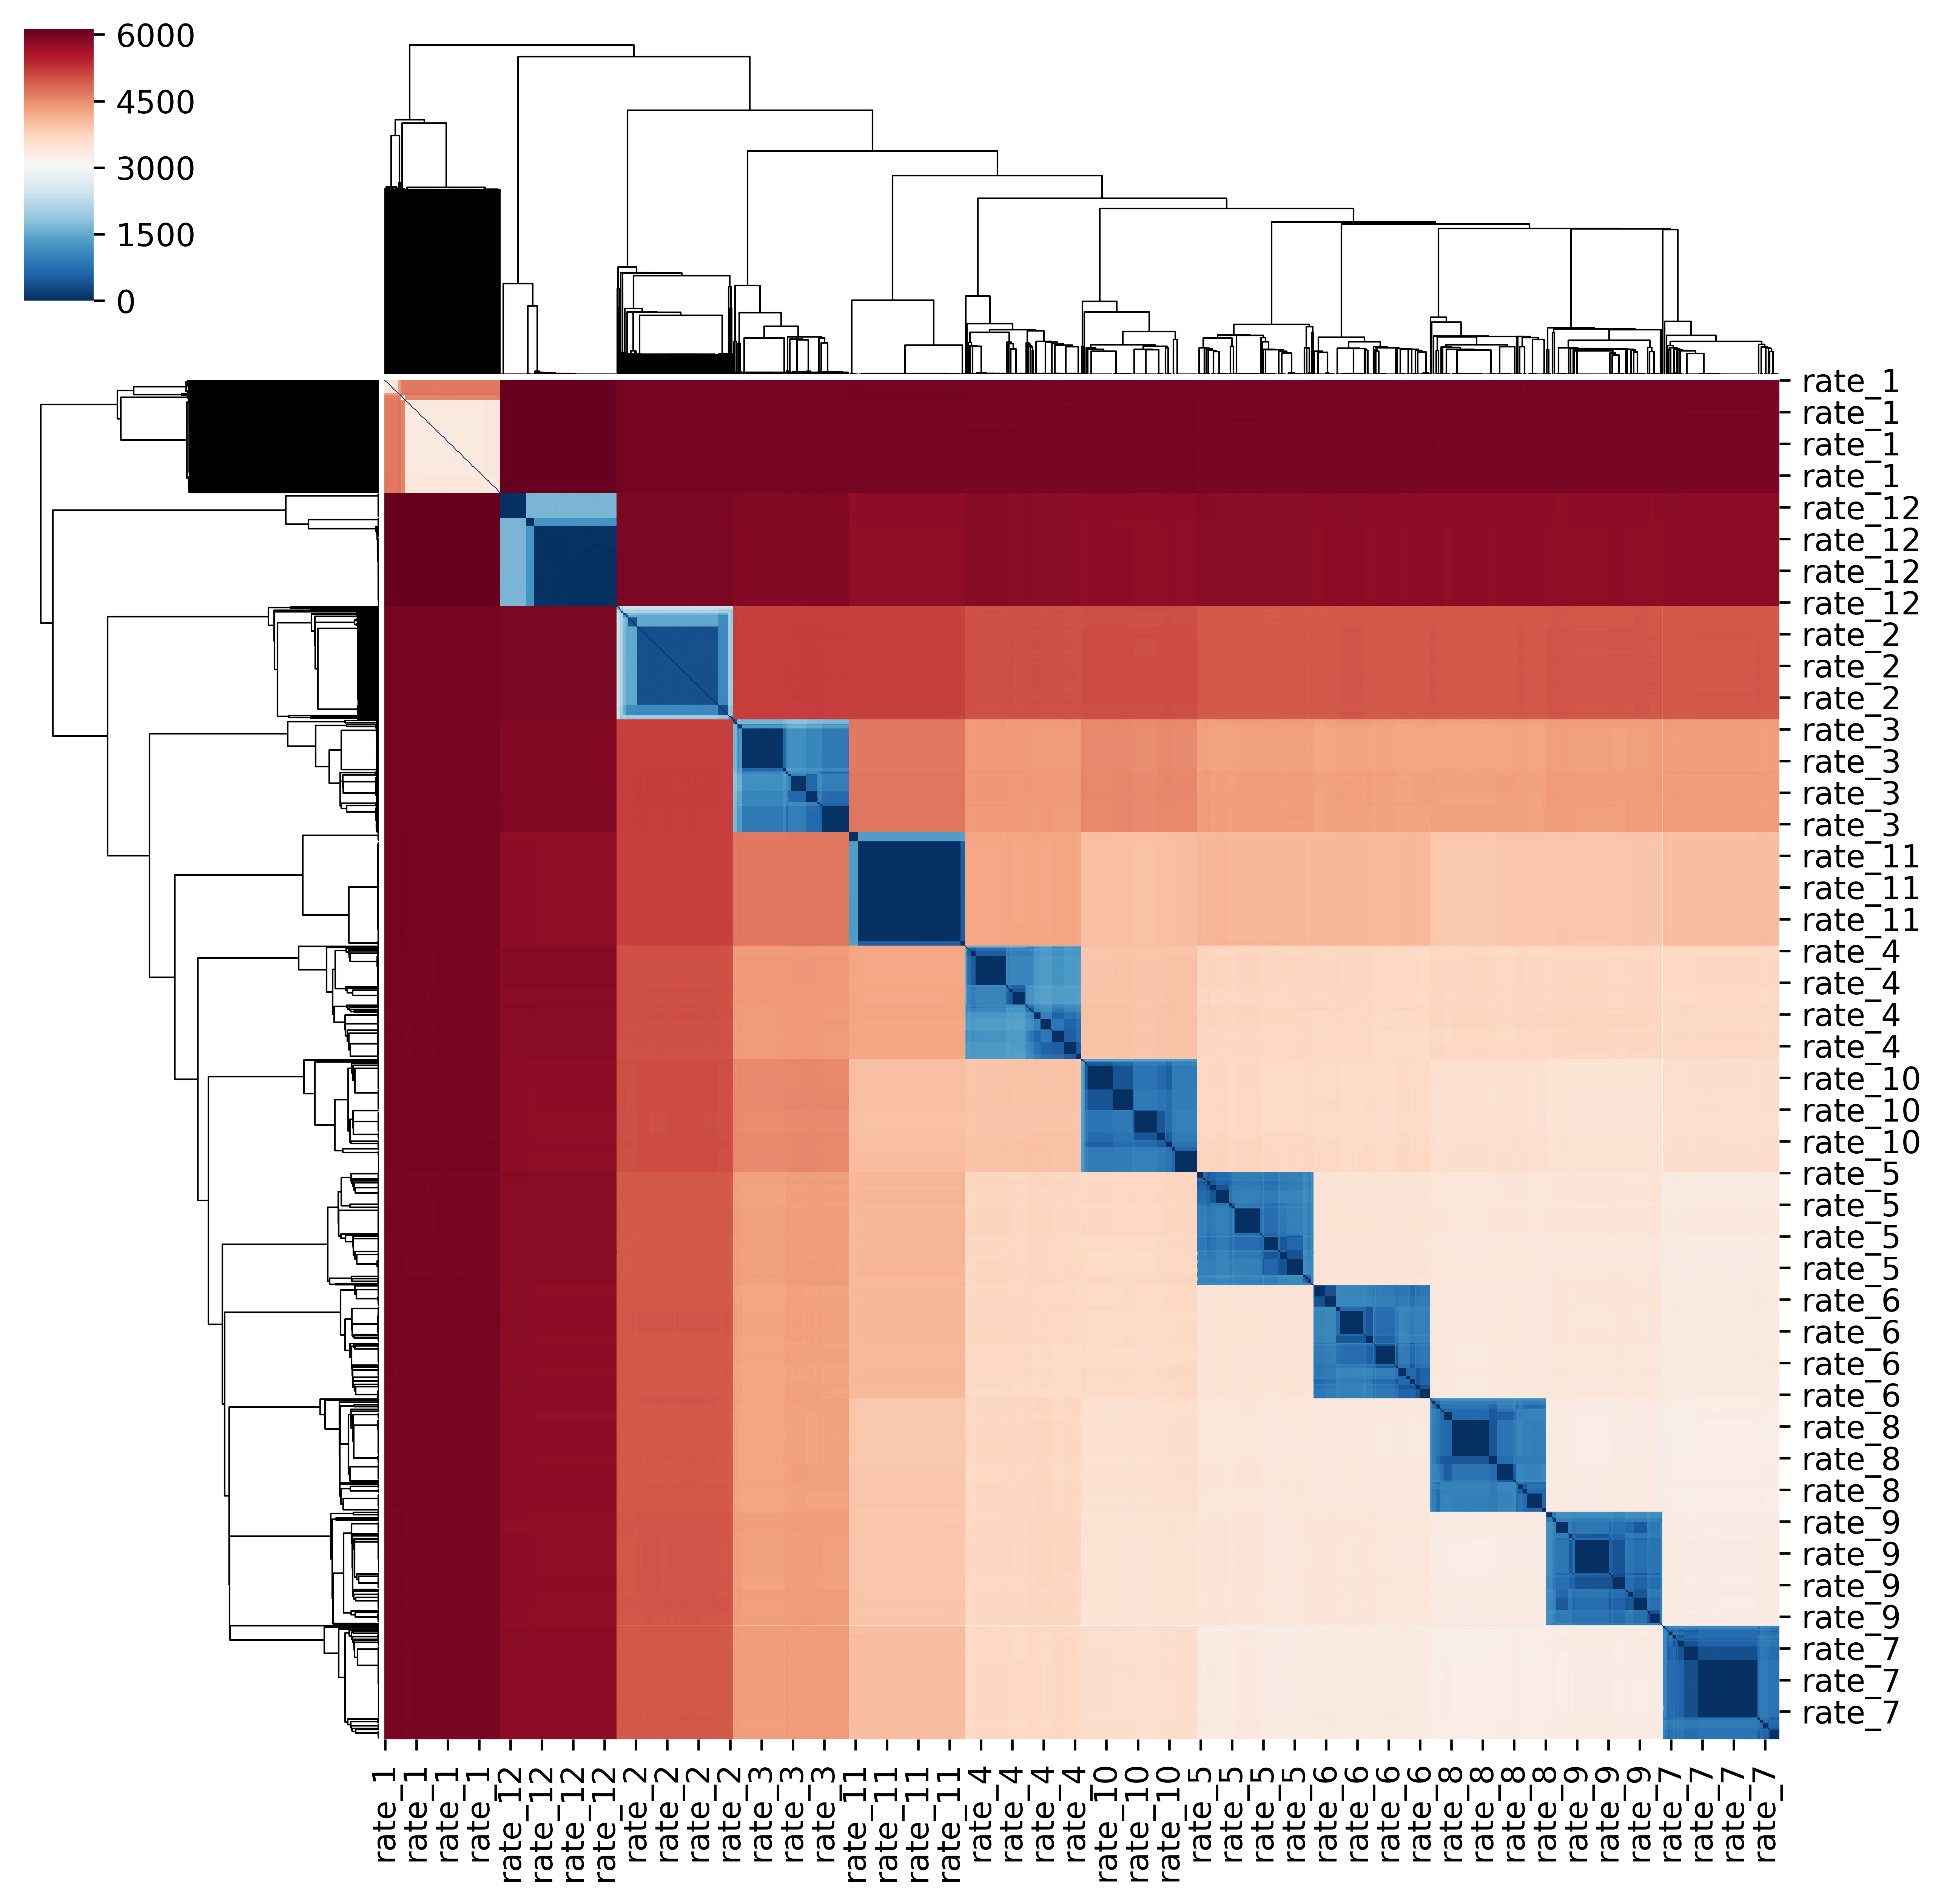

In [62]:
heatmap = sns.clustermap(df, col_linkage=tree_linkage, row_linkage=tree_linkage,
                         cmap='RdBu_r')
heatmap.fig.set_dpi(600)

In [ ]:
for filename in os.listdir('selected_categories/'):
    if not filename.endswith('.boottrees'):
        continue
    ufboot = open('selected_categories/%s' % filename).read().split('\n')
    ufboot.pop()
    trees.extend(ufboot)
    names.extend([filename.replace('.aln.boottrees', '')]*len(ufboot))

In [ ]:
out = open('rf_trees.treelist', 'w')
out.write('\n'.join(trees))
out.close()

subprocess.call(['iqtree', '-nt', '15', '-redo',
                 '-t', 'rf_trees.treelist', '-rf_all'])

In [ ]:
distances = []
for line in open('rf_trees.treelist.rfdist').readlines()[1:]:
    line = line.split()[1:]
    distances.append([float(value) for value in line])

df = pd.DataFrame(index=names, columns=names, data=distances)

In [ ]:
intra_distances = pd.DataFrame(columns=['tree group', 'distance'])
for category in ['missing-11_12', 'missing-1_2', 'missing-1_2_11_12', 'ribosomal_concat.fasta.boottrees']:
    category_indexes = df.index[df.index == category]
    tmp_df = df.loc[df.index== category, df.columns== category].copy()
    condensed_df = squareform(tmp_df.values)
    intra_distances = intra_distances.append(
        pd.DataFrame(
            data=zip([category]*len(condensed_df), condensed_df), 
            columns=['tree group', 'distance']),
        ignore_index=True)

fig, axs = plt.subplots(nrows=2, sharex=False, dpi=180, figsize=(10,8))
sns.boxplot(x='tree group', y='distance', data=intra_distances, ax=axs[0])
axs[0].set_ylabel('Distances within rate category trees')

whole_alignment_indexes = df.index[df.index.str.startswith('ribosomal_concat_ml_tree')]
distances_to_whole_aln = pd.DataFrame(columns=['tree group', 'distance'])
for category in ['missing-11_12', 'missing-1_2', 'missing-1_2_11_12', 'ribosomal_concat.fasta.boottrees']:
    category_indexes = df.index[df.index == category]
    tmp_df = df.loc[df.index==category, df.columns=='ribosomal_concat_ml_tree'].copy()
    condensed_df = tmp_df.values.flatten()
    distances_to_whole_aln = distances_to_whole_aln.append(pd.DataFrame(
            data=zip([category]*len(condensed_df), condensed_df), 
            columns=['tree group', 'distance']),
        ignore_index=True)
    
sns.boxplot(x='tree group', y='distance', data=distances_to_whole_aln, ax=axs[1])
axs[1].set_ylabel('Distances to whole alignment trees')
axs[1].set_xlabel('Rate categories')

fig.tight_layout()

In [ ]:
from scipy.stats import wilcoxon
for group1, group2 in combinations(intra_distances['tree group'].unique(), 2):
    i = intra_distances.distance[intra_distances['tree group'] == group1].values
    j = intra_distances.distance[intra_distances['tree group'] == group2].values
    if len(i) > len(j):
        i = i[:len(j)]
    else:
        j = j[:len(i)]
    print '%s VS %s: %f' % (group1, group2, ttest_ind(i, j).pvalue)

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(intra_distances.distance[intra_distances['tree group'] == 'missing-1_2'].values,
            ax=ax, shade=True, label='missing-1_2')
sns.kdeplot(intra_distances.distance[intra_distances['tree group'] == 'ribosomal_concat.fasta.boottrees'].values,
            ax=ax, shade=True, label='ribosomal_concat.fasta.boottrees')

In [ ]:
for group1, group2 in combinations(distances_to_whole_aln['tree group'].unique(), 2):
    i = distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == group1].values
    j = distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == group2].values
    if len(i) > len(j):
        i = i[:len(j)]
    else:
        j = j[:len(i)]
    print '%s VS %s: %f' % (group1, group2, ttest_ind(i, j).pvalue)

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == 'missing-1_2'].values,
            ax=ax, shade=True, label='missing-1_2')
sns.kdeplot(distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == 'ribosomal_concat.fasta.boottrees'].values,
            ax=ax, shade=True, label='ribosomal_concat.fasta.boottrees')


In [ ]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=6)
coords    = embedding.fit_transform(df.values)
coords_df = pd.DataFrame(data=coords, columns='x y'.split(), index=df.index)
        
coords_df['gene_type'] = coords_df.index.tolist()
coords_df.loc[coords_df['gene_type'] == 'ribosomal_concat_ml_tree', 'gene_type'] = 'whole alignment'

In [ ]:
markers = {num:'o' for num in ['missing-11_12', 'missing-1_2']}
markers['missing-1_2_11_12'] = '^'
markers['ribosomal_concat.fasta.boottrees'] = 's'
markers['whole alignment'] = 'X'
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
sns.scatterplot(x='x', y='y', hue='gene_type',
                style='gene_type', data=coords_df,
                ax=ax, s=80, palette="Set2",
                markers=markers, alpha=1)
ax.set_xlabel('')
ax.set_ylabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], markerscale=1.5,
          loc=10, bbox_to_anchor=(0.5, -0.1), ncol=5, frameon=False)

In [ ]:
cmap        = plt.get_cmap('rainbow')
color_range = ['#%02x%02x%02x' % cmap(value, bytes=True)[:3] for value in np.linspace(0, 1, 6)]
data        = []
marker_shapes = ['circle', 'square', 'triangle-up', 'diamond', 'star']
for gene_type, (shape,color) in zip(coords_df.gene_type.unique(), product(marker_shapes, color_range)):
    tmp    = coords_df[coords_df.gene_type == gene_type]
    
    data.append(
        go.Scatter(x=tmp.x.values, y=tmp.y.values, mode='markers', text=tmp.index,
               name=gene_type, hoverinfo='text', showlegend=True,
               marker=dict(size=[20 if index.endswith('.bmge') or index.startswith('missing') else 10
                                   for index in tmp.index],color=color, opacity=.7,
                           symbol=['star' if index.endswith('.bmge') or index.startswith('missing') else shape
                                   for index in tmp.index])
        )
    )
layout    = go.Layout(title='Geodesic distances', hovermode='closest', width=1200, height=1000)
fig       = go.Figure(data=data, layout=layout)
iplot(fig)